In [1]:
#Chercher spark quand il n'est pas dans le path par default
import findspark
findspark.init()

In [2]:
from pyspark import SparkContext,SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import element_at, reverse, split, col
from pyspark.ml.image import ImageSchema
import os
import pyspark
import PIL.Image as Images
from IPython.display import Image
import io
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from pyspark.ml.feature import PCA as PCAml
import pandas as pd
from PIL import Image, ImageOps
import cv2
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from pyspark.sql.functions import col, pandas_udf, PandasUDFType


2021-09-22 16:44:49.650959: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-22 16:44:49.650992: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## 1. Initialisation de la configuration
### Version AWS

In [3]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
#initilisation des package d'environnement AWS
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.amazonaws:aws-java-sdk-pom:1.10.34,org.apache.hadoop:hadoop-aws:2.7.2 pyspark-shell'
#initilisation du path
path_image = 's3a://bucket-projet8-oc/fruits-360_dataset/fruits-360/Training/'
#initilisation du creddentials
path_cred=os.path.join(os.getcwd(),".aws/credentials")
#lecture du credentials
with open(path_cred,'r') as f:
    msg=f.read()
    ID = msg.split('\n')[1].split(' ')[2]
    KEY = msg.split('\n')[2].split(' ')[2]
#import des clés d'accès à S3
os.environ["AWS_ACCESS_KEY_ID"]=ID
os.environ["AWS_SECRET_ACCESS_KEY"]=KEY

#initilisation du spark context & spark session
sc=SparkContext.getOrCreate()
hadoop_conf=sc._jsc.hadoopConfiguration()
hadoop_conf.set("fs.s3.impl","org.apache.hadoop.fs.s3a.S3AFileSystem")
spark=SparkSession.builder.appName("P8_aws").getOrCreate()

:: loading settings :: url = jar:file:/usr/local/spark/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/ubuntu/.ivy2/cache
The jars for the packages stored in: /home/ubuntu/.ivy2/jars
com.amazonaws#aws-java-sdk-pom added as a dependency
org.apache.hadoop#hadoop-aws added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-8d4e9fe4-842c-4584-a0e4-a54b89d93100;1.0
	confs: [default]
	found com.amazonaws#aws-java-sdk-pom;1.10.34 in central
	found org.apache.hadoop#hadoop-aws;2.7.2 in central
	found org.apache.hadoop#hadoop-common;2.7.2 in central
	found org.apache.hadoop#hadoop-annotations;2.7.2 in central
	found com.google.guava#guava;11.0.2 in central
	found com.google.code.findbugs#jsr305;3.0.0 in central
	found commons-cli#commons-cli;1.2 in central
	found org.apache.commons#commons-math3;3.1.1 in central
	found xmlenc#xmlenc;0.52 in central
	found commons-httpclient#commons-httpclient;3.1 in central
	found commons-logging#commons-logging;1.1.3 in central
	found commons-codec#commons-codec;1.4 in central
	found commons-io#comm

### Version Local

In [4]:
'''
sc=SparkContext.getOrCreate()
spark=SparkSession.builder.appName("P8_aws").getOrCreate()
path_image="data/fruits-360_dataset/fruits-360/Training/"

'''

'\nsc=SparkContext.getOrCreate()\nspark=SparkSession.builder.appName("P8_aws").getOrCreate()\npath_image="data/fruits-360_dataset/fruits-360/Training/"\n\n'

## 2. Import des données
- lecture des donnée en formats binary
- creation d'une colonne "class" qui est la catégorie du produit (nom du fruit)
- limitation d'import à 1000 images

In [5]:
#  + creation d'une colonne "class"
image_df=spark.read.format('binaryFile') \
.option("pathGlobalFilter","*.jpg") \
.option("recursiveFileLookup","true") \
.load(path_image) \
.withColumn("class",element_at(reverse(split(col("path"),"/")),2)) \
.limit(1000)

21/09/22 16:45:05 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties
21/09/22 16:45:05 WARN ApacheUtils: NoSuchMethodException was thrown when disabling normalizeUri. This indicates you are using an old version (< 4.5.8) of Apache http client. It is recommended to use http client version >= 4.5.9 to avoid the breaking change introduced in apache client 4.5.7 and the latency in exception handling. See https://github.com/aws/aws-sdk-java/issues/1919 for more information


## 3. Affichage des données

In [6]:
#schéma des colonnes
image_df.printSchema()

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- class: string (nullable = true)



In [7]:
#affichage des données
image_df.repartition(200).show(3)

+--------------------+-------------------+------+--------------------+--------------+
|                path|   modificationTime|length|             content|         class|
+--------------------+-------------------+------+--------------------+--------------+
|s3a://bucket-proj...|2021-08-31 17:27:05|  6647|[FF D8 FF E0 00 1...|     Pineapple|
|s3a://bucket-proj...|2021-08-31 17:28:02|  6627|[FF D8 FF E0 00 1...|      Rambutan|
|s3a://bucket-proj...|2021-08-31 17:27:01|  7161|[FF D8 FF E0 00 1...|Pineapple Mini|
+--------------------+-------------------+------+--------------------+--------------+
only showing top 3 rows



In [8]:
# la taille du dataset importé
image_part2=image_df.repartition(2)
print(image_part2.count(),len(image_df.columns))

1000 5


## 4. Preprocessing + Feature extraction
### Initialisation du model Resnet50

In [9]:
# Utilisation du réseau de neurones Resnet-50 déjà pré-entraîné
# On ne conserve pas le pooling final
# On retire la couche fully-connected: (include_top=False) 
model = ResNet50(include_top=False)

2021-09-22 17:05:21.200430: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-09-22 17:05:21.200491: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-09-22 17:05:21.200518: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-31-10-32): /proc/driver/nvidia/version does not exist
2021-09-22 17:05:21.200857: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
# On utilise le broadcast de SparkContext pour partager dans le cluster des valeurs  (ICI les poids du modéle) en lecture-seule
# Cela permet de réduire les coûts de communication 

bc_model_weights = sc.broadcast(model.get_weights())

def model_fn():
    """
    Retourne un modèle ResNet50 avec la couche supérieure enlevée (fully-connected) et 
    des pondérations en broadcast déjà pré-entraînés. 
    On retire la couche supérieure car c'est celle qui permet de faire une classification, or 
    ici on se sert du modéle pour extraire des features.
    """
    model = ResNet50(weights=None, include_top=False, pooling='avg')
    #on ajoute les pondérations
    model.set_weights(bc_model_weights.value)
    
    return model

### Definition du preprocessing 

In [11]:
#preprocessing et extraction de features
def preprocess(content):
    
    img = Image.open(io.BytesIO(content)).resize([224, 224])   # on ouvre et redimensionne l'image car Resnet 50 ne prend 
                                                               #  en charge que des images de taille 224x224
    img = np.asarray(img) # Changer le type d'image en matrice          
    img = cv2.fastNlMeansDenoisingColored(img,None,10,10,7,21) # Flou rapide
    
    img= cv2.GaussianBlur(img, (5, 5), 0)
    
    arr = img_to_array(img) # Préparation au pre-process de Keras
    return preprocess_input(arr) # Fonction 'preprocess_input' de Keras utilisée dans le modèle ResNet50
                                 # c'est un ensemble de préprocessing propres à l'utilisation de ResNet 

### Definition du features extraction via Resnet50

In [12]:
def featurize_series(model, content_series):
    """
    Retourne un pd.Series des features de l'image, 
    """
    
    input = np.stack(content_series.map(preprocess))
  # La ligne de code suivante permet d'extraire les features des images
    preds = model.predict(input)
  # Pour certaines couches, les caractéristiques de sortie sont des tensors multidimensionnels
  # On aplatit les caractéristiques de tensors en vecteurs pour faciliter le stockage dans les dataframes Spark
  # la fonction flatten() envoie une copie du tableau réduit à une seule dimension 
    output = [p.flatten() for p in preds]
    return pd.Series(output)

### Passage en PandasUDF pour exploter les données

In [13]:
@pandas_udf('array<double>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    '''
    Cette méthode est un Itérateur Scalaire (pandas UDF signifiant User-Defined Functions) qui complète
    la fonction de featurisation.
    Cela renvoie une colonne Spark DataFrame de type ArrayType(FloatType).
    '''
  # Avec les pandas UDF Scalar Iterator, on peut charger le modèle une fois et le réutiliser ensuite
  # pour plusieurs lots de données. Cela permet d'amortir les frais liés au chargement de grands modèles.
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

/usr/local/spark/python/pyspark/sql/pandas/functions.py:389: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


In [14]:
image_df.repartition(4).show()

+--------------------+-------------------+------+--------------------+--------------+
|                path|   modificationTime|length|             content|         class|
+--------------------+-------------------+------+--------------------+--------------+
|s3a://bucket-proj...|2021-08-31 17:28:07|  7300|[FF D8 FF E0 00 1...|     Raspberry|
|s3a://bucket-proj...|2021-08-31 17:28:08|  7231|[FF D8 FF E0 00 1...|     Raspberry|
|s3a://bucket-proj...|2021-08-31 17:27:04|  6702|[FF D8 FF E0 00 1...|Pineapple Mini|
|s3a://bucket-proj...|2021-08-31 17:29:36|  6797|[FF D8 FF E0 00 1...|    Watermelon|
|s3a://bucket-proj...|2021-08-31 17:29:36|  6763|[FF D8 FF E0 00 1...|    Watermelon|
|s3a://bucket-proj...|2021-08-31 17:27:02|  7127|[FF D8 FF E0 00 1...|Pineapple Mini|
|s3a://bucket-proj...|2021-08-31 17:27:07|  6668|[FF D8 FF E0 00 1...|     Pineapple|
|s3a://bucket-proj...|2021-08-31 17:27:01|  7168|[FF D8 FF E0 00 1...|Pineapple Mini|
|s3a://bucket-proj...|2021-08-31 17:27:01|  7163|[FF D

### Transformation et extraction via les fonctions définis plus tôt

In [15]:
#On selectionne les données afin de créer une nouvelle df
features_df = image_df.repartition(200).select(col("path"),col("class"), featurize_udf("content").alias("features"))

In [16]:
features_df.show(10)

+--------------------+--------------+--------------------+
|                path|         class|            features|
+--------------------+--------------+--------------------+
|s3a://bucket-proj...|     Pineapple|[0.01226839516311...|
|s3a://bucket-proj...|Pineapple Mini|[0.70232343673706...|
|s3a://bucket-proj...|     Raspberry|[2.98044753074646...|
|s3a://bucket-proj...|Pineapple Mini|[0.99220997095108...|
|s3a://bucket-proj...|    Watermelon|[0.17628835141658...|
|s3a://bucket-proj...|     Raspberry|[2.20922064781188...|
|s3a://bucket-proj...|Pineapple Mini|[0.63443118333816...|
|s3a://bucket-proj...|    Watermelon|[0.26071700453758...|
|s3a://bucket-proj...|     Raspberry|[1.80497431755065...|
|s3a://bucket-proj...|Pineapple Mini|[0.00372549961321...|
+--------------------+--------------+--------------------+
only showing top 10 rows



## 5. Visualisation sur Pandas
- Image par defaut
- Image resize
- Image avec reduction de bruit
- Image Flou Gaussien
- Image apres préprocessing Resnet50

In [56]:
# Conversion de Spark to Pandas
pandasDF = image_df.toPandas()

In [57]:
pandasDF.head(1)['class'][0]

'Raspberry'

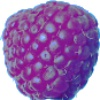

100 100
(100, 100, 3)


In [74]:
image = Images.open(io.BytesIO(pandasDF.content[1]))
display(image)
width, height = image.size
print(width, height)
arr = np.array(image)
print(arr.shape)

(224, 224, 3)


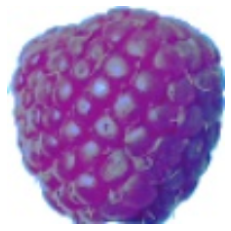

In [75]:
#resize 224/224
resizing = cv2.resize(arr, (224, 224))
plt.imshow(resizing)
plt.axis('off')
print(resizing.shape)

(224, 224, 3)


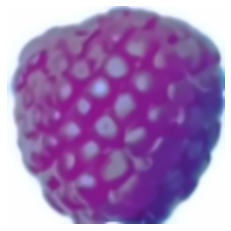

In [76]:
# Réduction de bruits
f_denoising = cv2.fastNlMeansDenoisingColored(resizing,None,10,10,7,21)
plt.imshow(f_denoising)
plt.axis('off')
print(f_denoising.shape)

(224, 224, 3)


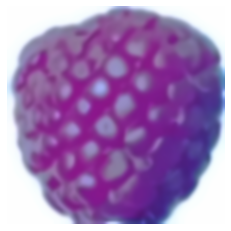

In [77]:
#Flou Gaussien
gauss = cv2.GaussianBlur(f_denoising,(5, 5),0)
plt.imshow(gauss)
plt.axis('off')
print(gauss.shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3)


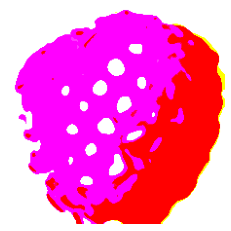

In [78]:
# Fonction de preprocessing du Resnet-50
arr = img_to_array(gauss)
arr_2 = preprocess_input(arr)
plt.imshow(arr_2)
plt.axis('off')
print(arr_2.shape)

## 6. PCA en Spark
### Tranformation en vector

In [17]:
#Ici on construit une User defined Fonction qui transforme les listes de features en vecteurs denses.
list_to_vector_udf = udf(lambda l: Vectors.dense(l), VectorUDT())

# On applique cette UDF à la colonne "features" de notre dataframe 
df_with_vectors = features_df.repartition(8).select(features_df["path"],
                                           features_df["class"],
                                           list_to_vector_udf(features_df["features"]).alias("features"))

### Recherche le nombre optimal pour la reduction de dimension PCA

In [18]:
# Recherche du nombre optimal de dimensions pour la réduction dimensionnelle des features
pca_opt = PCAml(k = 2048,inputCol="features", outputCol="features_pca")
model = pca_opt.fit(df_with_vectors)

comp_pca = model.explainedVariance

21/09/22 17:54:47 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
21/09/22 17:54:47 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
21/09/22 17:54:50 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
21/09/22 17:54:50 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


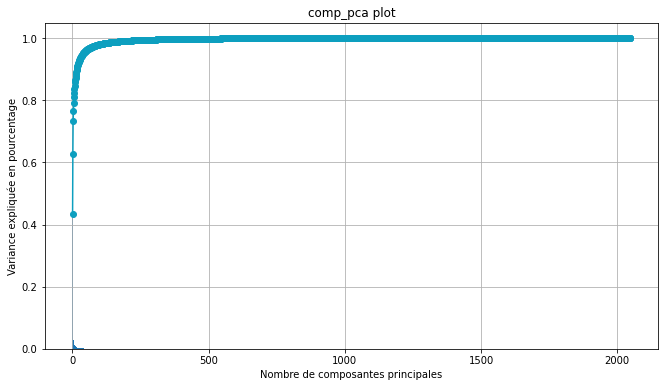

In [19]:
# comp_pca plot pour déterminer le nombre optimal de composantes principales
plt.figure(figsize=(11,6))
plt.bar(np.arange(len(comp_pca))+1, comp_pca)
plt.plot(np.arange(len(comp_pca))+1, comp_pca.cumsum(),c="#0D9FBF",marker='o')
plt.xlabel("Nombre de composantes principales")
plt.ylabel("Variance expliquée en pourcentage")
plt.title("comp_pca plot")
plt.grid()
plt.show(block=False)

In [20]:
# On chercher à  trouver le nombre de composantes principales à conserver.
# On se fixe ici de converser au moins 85 % de l'inertie .
nbr_pca=0
for i in range(50):
    a = comp_pca.cumsum()[i]
    if a >= 0.95:
        print("{} composantes principales expliquent au moins 95% de la variance totale".format(i))
        print("Valeur exacte de variance expliquée:{}%".format(a*100))
        nbr_pca=i
        break

39 composantes principales expliquent au moins 95% de la variance totale
Valeur exacte de variance expliquée:95.09560100422794%


### Definition du PCA avec le nombre optimal

In [22]:
pca = PCAml(k = nbr_pca, inputCol="features", outputCol="features_pca")
model = pca.fit(df_with_vectors)
df_pca = model.transform(df_with_vectors)
df_pca.show(5)

+--------------------+--------------+--------------------+--------------------+
|                path|         class|            features|        features_pca|
+--------------------+--------------+--------------------+--------------------+
|s3a://bucket-proj...|Pineapple Mini|[0.99220997095108...|[35.7555017501431...|
|s3a://bucket-proj...|     Raspberry|[1.80497431755065...|[-0.5236859977857...|
|s3a://bucket-proj...|     Raspberry|[1.91433095932006...|[-0.6589614092668...|
|s3a://bucket-proj...|    Watermelon|[0.11535932868719...|[1.39421570264296...|
|s3a://bucket-proj...|Pineapple Mini|[0.20476920902729...|[34.9707688171887...|
+--------------------+--------------+--------------------+--------------------+
only showing top 5 rows



## 7. Savegarde local / S3

In [ ]:
#df_pca.write.parquet("resultat_spark")

In [ ]:
#df_pca.write.parquet("s3a://bucket-projet8-oc/resultat_spark", mode='overwrite')

## 8. Projection du PCA

In [79]:
#Spark to Pandas
df_p = df_pca.toPandas()

In [80]:
df_p.head()

,path,class,features,features_pca
0,s3a://bucket-projet8-oc/fruits-360_dataset/fru...,Pineapple Mini,"[0.9922099709510803, 0.0, 3.753575325012207, 0...","[35.75550175014318, 6.110974382770357, -4.0283..."
1,s3a://bucket-projet8-oc/fruits-360_dataset/fru...,Raspberry,"[1.8049743175506592, 0.09274309873580933, 0.20...","[-0.5236859977857157, 18.827911103239977, 1.74..."
2,s3a://bucket-projet8-oc/fruits-360_dataset/fru...,Raspberry,"[1.9143309593200684, 0.10059909522533417, 0.32...","[-0.6589614092668306, 17.27965299056525, 3.086..."
3,s3a://bucket-projet8-oc/fruits-360_dataset/fru...,Watermelon,"[0.11535932868719101, 0.3778701722621918, 1.56...","[1.3942157026429607, -10.099965835576004, 1.77..."
4,s3a://bucket-projet8-oc/fruits-360_dataset/fru...,Pineapple Mini,"[0.20476920902729034, 0.0055505987256765366, 1...","[34.97076881718875, 3.9976233949157427, -2.744..."


### Creation d'un dataframe pour les features PCA

In [82]:
col=["class"]
df_final = pd.DataFrame(np.zeros((df_p.shape[0], nbr_pca)))
for i in range(nbr_pca):
    df_final.loc[:,i] = df_p["features_pca"].apply(lambda x : x[i])
    col.append("PCA n°{}".format(i+1))

df_final_pca = pd.concat([df_p['class'], df_final], axis=1)
df_final_pca.columns=col
print(df_final_pca.shape)
print(df_final_pca.columns)

(1000, 40)
Index(['class', 'PCA n°1', 'PCA n°2', 'PCA n°3', 'PCA n°4', 'PCA n°5',
       'PCA n°6', 'PCA n°7', 'PCA n°8', 'PCA n°9', 'PCA n°10', 'PCA n°11',
       'PCA n°12', 'PCA n°13', 'PCA n°14', 'PCA n°15', 'PCA n°16', 'PCA n°17',
       'PCA n°18', 'PCA n°19', 'PCA n°20', 'PCA n°21', 'PCA n°22', 'PCA n°23',
       'PCA n°24', 'PCA n°25', 'PCA n°26', 'PCA n°27', 'PCA n°28', 'PCA n°29',
       'PCA n°30', 'PCA n°31', 'PCA n°32', 'PCA n°33', 'PCA n°34', 'PCA n°35',
       'PCA n°36', 'PCA n°37', 'PCA n°38', 'PCA n°39'],
      dtype='object')


In [85]:
df_final_pca.head(5)

,class,PCA n°1,PCA n°2,PCA n°3,PCA n°4,PCA n°5,PCA n°6,PCA n°7,PCA n°8,PCA n°9,...,PCA n°30,PCA n°31,PCA n°32,PCA n°33,PCA n°34,PCA n°35,PCA n°36,PCA n°37,PCA n°38,PCA n°39
0,Pineapple Mini,35.755502,6.110974,-4.028322,3.650158,-7.354092,2.995799,0.541344,4.518951,3.191055,...,0.039258,1.466842,0.718393,-1.334259,-4.718802,2.976064,2.206761,-6.914142,-2.595335,-4.480429
1,Raspberry,-0.523686,18.827911,1.743962,0.775184,-5.098537,0.192505,1.778860,0.928273,2.692519,...,-0.171606,1.135149,0.638184,-1.655203,-2.963493,1.168692,2.459468,-7.211335,-0.218060,-4.224804
2,Raspberry,-0.658961,17.279653,3.086590,0.241211,-4.837712,0.234609,0.750315,-0.177079,2.917962,...,0.649208,1.668037,0.714262,0.278780,-4.265266,3.712655,3.421162,-6.204656,-2.453848,-4.381631
3,Watermelon,1.394216,-10.099966,1.771039,-7.525646,-0.892615,11.981708,-0.006818,2.690418,4.149867,...,-0.262853,0.142571,-0.863889,-1.171528,-4.194765,2.013118,2.745597,-8.199521,-2.220235,-4.637717
4,Pineapple Mini,34.970769,3.997623,-2.744391,4.476670,-5.241422,-0.508043,-4.696602,-4.251865,-0.896496,...,-0.542465,0.864024,0.653547,-1.621890,-3.874983,1.135819,1.155888,-8.425514,-3.526820,-3.969912


### Projection PCA sur 2 axes

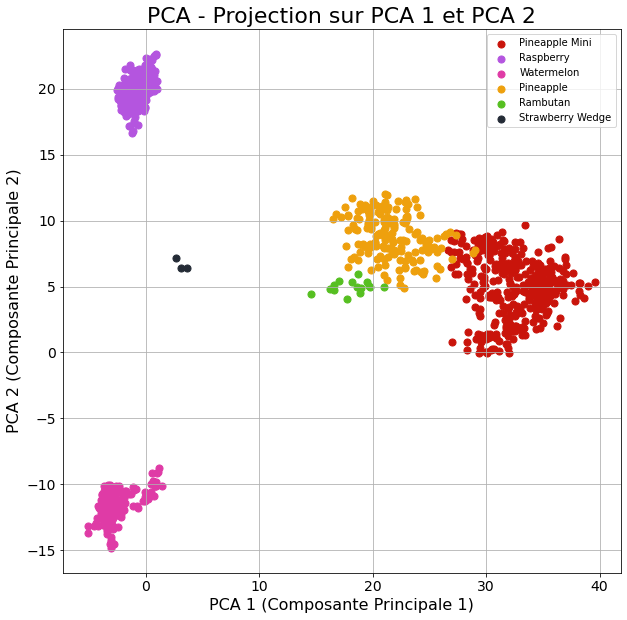

In [84]:
# Visualisation des différents fruits par projection sur les 2 axes principaux d'inertie

plt.figure(figsize=(10,10))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('PCA 1 (Composante Principale 1)',fontsize=16)
plt.ylabel('PCA 2 (Composante Principale 2)',fontsize=16)
couleurs=["#c9140b","#b455df","#df3ba6","#eea00d","#56bf21","#242b36","#00cfd4","#fbe042","#0c34ff","#bb5cd4","#fd00ff","#ff008d"]
i=0
for fruit in df_final_pca['class'].unique():
    dfred = df_final_pca.loc[df_final_pca['class']==fruit]
    plt.scatter(dfred['PCA n°1'], dfred['PCA n°2'], label=fruit, s=50,c=couleurs[i])
    i+=1

plt.title("PCA - Projection sur PCA 1 et PCA 2",fontsize=22)
plt.grid()
plt.legend()    
plt.show()